In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Import Libraries

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from geopy.distance import distance

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout, Bidirectional

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


# 2. Load Data

In [5]:
data = pd.read_csv('../Dataset/demand.csv').dropna()
data = data.drop_duplicates(subset=['Total Price', 'Base Price'])
data = data.drop(columns=['ID', 'Store ID'])
data

,Total Price,Base Price,Units Sold
0,99.0375,111.8625,20
1,99.0375,99.0375,28
2,133.9500,133.9500,19
4,141.0750,141.0750,52
5,227.2875,227.2875,18
...,...,...,...
150048,158.8875,217.3125,262
150055,357.6750,483.7875,34
150061,175.9875,174.5625,107
150080,165.3000,194.5125,268


# 3. Initial Analysis

### 3.1. Metadata

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9160 entries, 0 to 150106
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total Price  9160 non-null   float64
 1   Base Price   9160 non-null   float64
 2   Units Sold   9160 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 286.2 KB


In [7]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Total Price,9160.0,189.144404,87.496012,41.325,133.9500,174.5625,213.0375,562.1625
Base Price,9160.0,232.403343,99.597821,61.275,177.4125,218.7375,242.2500,562.1625
Units Sold,9160.0,88.434279,110.361964,1.000,28.0000,52.0000,104.0000,1341.0000


In [8]:
data.isnull().sum()

Total Price    0
Base Price     0
Units Sold     0
dtype: int64

In [33]:
data.duplicated().sum()

95173

In [9]:
data['Units Sold'].max()

1341

### 3.2. Columns Processing

In [10]:
def change_dtypes(data):
    data['Total Price'] = data['Total Price'].astype('float32')
    data['Base Price'] = data['Base Price'].astype('float32')
    data['Units Sold'] = data['Units Sold'].astype('int16')
    return data

data = change_dtypes(data)

In [11]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']

print(f'Numerical Columns Train   : {numerical_columns}')
print(f'Categorical Columns Train : {categorical_columns}')

Numerical Columns Train   : ['Total Price', 'Base Price', 'Units Sold']
Categorical Columns Train : []


# 4. EDA

<Axes: xlabel='Units Sold'>

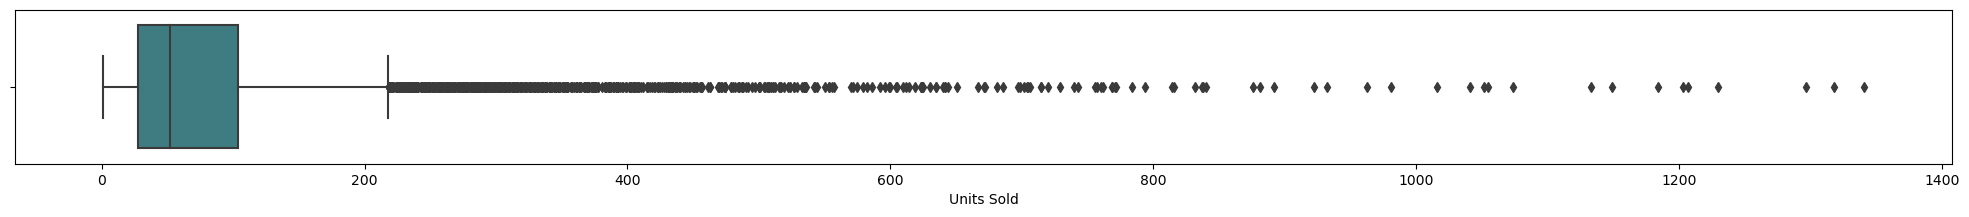

In [12]:
fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['Units Sold'], palette="crest")

In [13]:
print(data['Units Sold'].quantile(0.25))
print(data['Units Sold'].quantile(0.75))

28.0
104.0


<Axes: xlabel='Units Sold'>

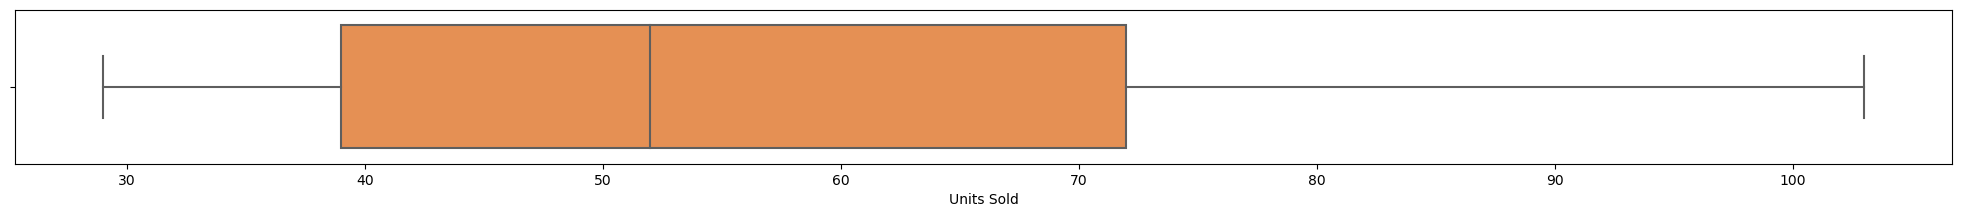

In [14]:
Q1 = data['Units Sold'].quantile(.25)
Q3 = data['Units Sold'].quantile(.75)

data = data[(data['Units Sold'] > Q1) & (data['Units Sold'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x = data['Units Sold'], palette="Oranges")

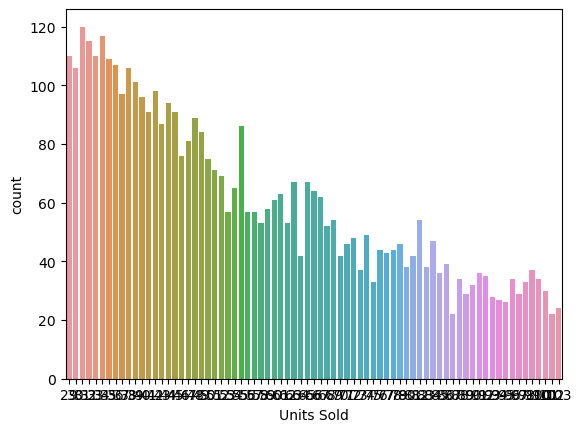

In [15]:
ax = sns.countplot(data, x = data['Units Sold'])

Text(0.5, 1.0, 'Correlation Matrix')

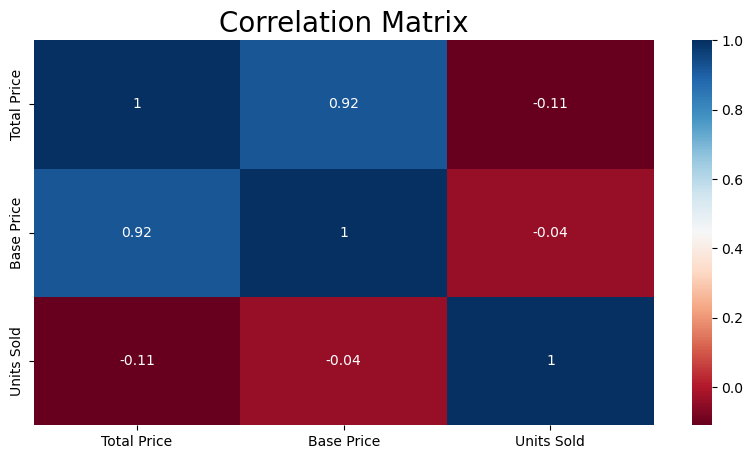

In [16]:
corr_data = data.corr().round(2)

plt.figure(figsize=(10, 5))
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 5. Regression Algoritms

In [124]:
X = data.drop(columns=['Units Sold'])
Y = data['Units Sold']

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(57620, 2)
(14405, 2)


c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [131]:
adaboost = AdaBoostRegressor(n_estimators = 100, random_state = 42)
bagging = BaggingRegressor(n_jobs = -1)
extraTrees = ExtraTreesRegressor(max_depth = 100, n_jobs = -1, random_state = 42)
gradient = GradientBoostingRegressor(max_depth = 100, n_estimators = 100, learning_rate = .01,  random_state = 0)
randomForest = RandomForestRegressor(max_depth = 100, random_state = 42, n_jobs = -1)
histGradientBoosting = HistGradientBoostingRegressor()
XGB = XGBRegressor(n_jobs = -1)
knn = KNeighborsRegressor(n_jobs = -1)
decisionTree = DecisionTreeRegressor( max_depth = 100, random_state = 42)

model = StackingRegressor([
    # ('bagging', bagging),
    ('extraTrees', extraTrees),
    # ('randomforest', randomForest),
    # ('decisionTree', decisionTree),
    # ('adaboost', adaboost),
    # ('gradient', gradient),
    # ('histGradientBoosting', histGradientBoosting),
    # ('XGB', XGB),
    # ('knn', knn),

], n_jobs=-1)

In [132]:
model.fit(X_train, y_train)

StackingRegressor(estimators=[('extraTrees',
                               ExtraTreesRegressor(max_depth=100, n_jobs=-1,
                                                   random_state=42))],
                  n_jobs=-1)

In [133]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))

Train Score        : 17.94 %
Test Score         : 8.91 %
R Squared Error    : 0.09
Mean Squared Error : 114.9


In [25]:
train_predictions = model.predict(X_test).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

        Train Predictions  Actuals        Diff
144782          37.861385       41    3.138615
117             27.671541       13   14.671541
77408          187.212752      339  151.787248
62193           19.972180       14    5.972180
143901          15.702143        4   11.702143
748169.1451298937 / 30030


In [26]:
print(train_results['Diff'].mean())

24.914057446882907


# 6. Neural Network

In [32]:
X = data.drop(columns=['Units Sold'])
Y = data['Units Sold']

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True)
# scalar = MinMaxScaler(feature_range=(0,1))
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)
X_val = scalar.fit_transform(X_val)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(3198, 2)
(902, 2)
(456, 2)


c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [34]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform', input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    # model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear', kernel_initializer='he_uniform'))
    
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    # model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True,  input_shape = (X_train.shape[1],1)))
    # model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

# model = DNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

# opt = SGD(learning_rate=0.01, momentum=0.9)
opt = Adam(learning_rate = 0.001)

# model.compile(loss='mse', optimizer=opt, metrics=['mse'])
model.compile(loss='mean_absolute_error', optimizer = opt)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 64)                12864     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [35]:
num_epoch = 50
batch_size = 64

history = model.fit(X_train, y_train, 
                    batch_size = batch_size, epochs = num_epoch,
                    validation_data = (X_val, y_val)
                    )

Epoch 1/50
50/50 [==============================] - 1s 10ms/step - loss: 55.8673 - val_loss: 55.6357
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 51.5210 - val_loss: 46.2860
Epoch 3/50
50/50 [==============================] - 0s 5ms/step - loss: 39.1176 - val_loss: 34.6724
Epoch 4/50
50/50 [==============================] - 0s 4ms/step - loss: 30.8517 - val_loss: 28.6726
Epoch 5/50
50/50 [==============================] - 0s 4ms/step - loss: 25.8483 - val_loss: 24.7141
Epoch 6/50
50/50 [==============================] - 0s 4ms/step - loss: 22.7391 - val_loss: 22.5092
Epoch 7/50
50/50 [==============================] - 0s 4ms/step - loss: 20.8170 - val_loss: 21.1577
Epoch 8/50
50/50 [==============================] - 0s 4ms/step - loss: 19.5834 - val_loss: 20.1974
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 18.7652 - val_loss: 19.5204
Epoch 10/50
50/50 [==============================] - 0s 4ms/step - loss: 18.2082 - val_loss: 19.048

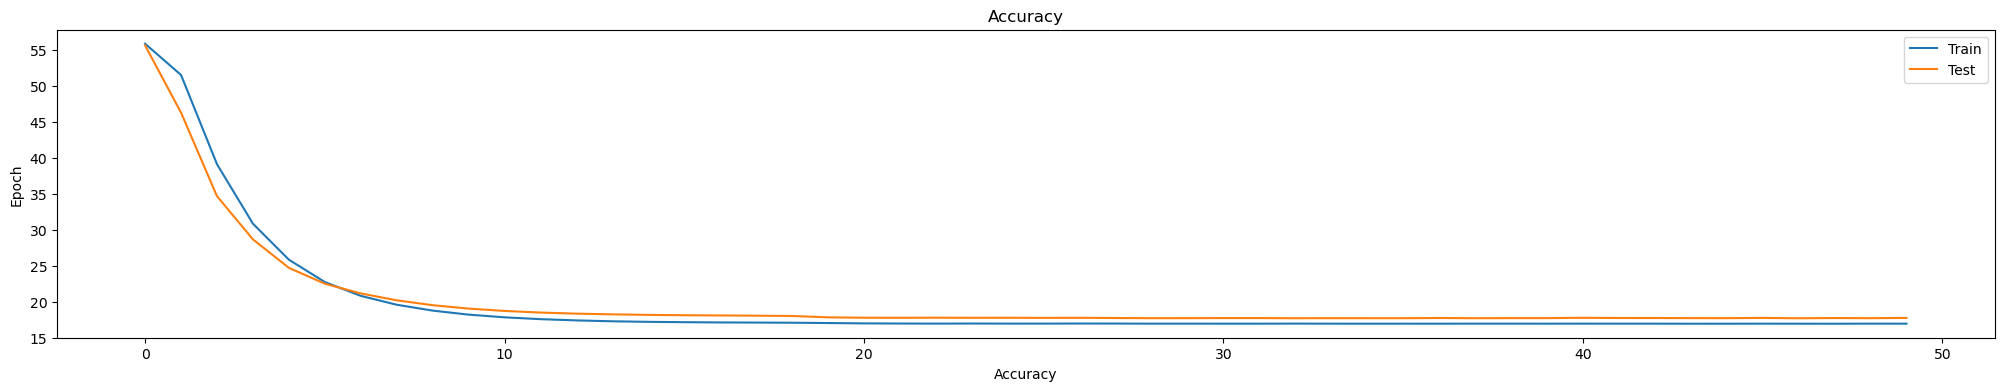

In [36]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [37]:
y_pred = model.predict(X_test, verbose = 0)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))

R Squared Error    : -0.04
Mean Squared Error : 441.71


In [38]:
train_predictions = model.predict(X_test, verbose=0).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].mean(), '-', (train_results['Diff'].sum()))

        Train Predictions  Actuals       Diff
8241            53.217976       47   6.217976
22669           53.187206       38  15.187206
135915          53.151756       58   4.848244
28893           53.121449       60   6.878551
22115           47.899921       36  11.899921
17.114218 - 15437.024


In [39]:
pred_df = data.copy()

x_test = pred_df.drop(columns=['Units Sold'])
train_predictions = model.predict(x_test, verbose=0).flatten()

pred_df['Prediction'] = train_predictions
pred_df

,Total Price,Base Price,Units Sold,Prediction
4,141.074997,141.074997,52,-7.363810
6,327.037506,327.037506,47,-6.986985
7,210.899994,210.899994,50,-7.150609
8,190.237503,234.412506,82,-7.300456
11,98.324997,98.324997,40,-7.679315
...,...,...,...,...
149953,247.237503,376.912506,64,-7.200465
149999,232.987503,259.350006,48,-7.154379
150000,235.837494,253.649994,43,-7.136126
150024,356.250000,475.237488,36,-6.992160
